### **Notebook to make predictions with reprocessed Henson data and EFLUX2 and SPOT** 

##### **Import python packages**

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import cobra
import scipy.stats
#import cplex
%matplotlib inline

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
from matplotlib.cbook import get_sample_data
import matplotlib.image as mpimg

from edd_utils import login, export_study, export_metadata

##### **Load data**

In [2]:
# Study to Download
study_slug = 'biodesign_henson2018_reprocessed'
# EDD server
edd_server = 'public-edd.jbei.org'
user       = 'schenkch'

In [3]:
session = login(edd_server=edd_server, user=user)

df = export_study(session, study_slug, edd_server=edd_server)
#df.head()

Password for schenkch:  ···············


##### **Filter transcriptomics data from all EDD data into different dataframes**

In [4]:
df_Trans = df[df['Protocol'].str.contains('Transcriptomics')]
df_Trans.head()

,Study ID,Study Name,Line ID,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
0,14409,Biodesign_Henson2018_reprocessed,14905,WT-M-R1,R. Opacus wild type strain with Mixture of all...,Transcriptomics,14948,WT-M-R1,NaN,WP_000104864_1,0,FPKM,0.0,20.0
1,14409,Biodesign_Henson2018_reprocessed,14905,WT-M-R1,R. Opacus wild type strain with Mixture of all...,Transcriptomics,14948,WT-M-R1,NaN,WP_000104864_1,0,FPKM,0.0,32.0
2,14409,Biodesign_Henson2018_reprocessed,14906,WT-M-R2,R. Opacus wild type strain with Mixture of all...,Transcriptomics,14949,WT-M-R2,NaN,WP_000104864_1,0,FPKM,0.0,20.0
3,14409,Biodesign_Henson2018_reprocessed,14906,WT-M-R2,R. Opacus wild type strain with Mixture of all...,Transcriptomics,14949,WT-M-R2,NaN,WP_000104864_1,0,FPKM,0.0,32.0
4,14409,Biodesign_Henson2018_reprocessed,14907,WT-M-R3,R. Opacus wild type strain with Mixture of all...,Transcriptomics,14950,WT-M-R3,NaN,WP_000104864_1,0,FPKM,0.0,20.0


##### **Load Genome Scale Model**

In [5]:
file_name =  '../GSMs/Ropacus_annotated_curated_with_phenol_custom_biomass.xml'
model = cobra.io.read_sbml_model(file_name)

##### **Import EFLUX2 and SPOT Code**

In [6]:
OptlangDir = '../EFLUX2_SPOT'
sys.path.append(OptlangDir)
from ensemblemethods import EFlux2,SPOT

##### **Transform data to dataframe with just index as gene identifiers and one column for values**
##### !!!!TODO: Generalize for multiple time points


In [7]:
#Function to construct df from EFLUX2 and SPOT functions: Needs to be modified for multiple time points!!!!!
def constructTransdffrompred(transdata, linename, conditionstring):
    transdataPhe = transdata[transdata['Line Description'].str.contains(conditionstring)]
    transdataWTPR1 = transdataPhe[transdataPhe['Line Name']==linename]
    transdataWTPR1new = transdataWTPR1.filter(['Value', 'Measurement Type'])#pd.DataFrame(data=df_TransWTPR1.loc[:,'Value'], index=df_TransWTPR1['Measurement Type'])
    transdataWTPR1new2 = transdataWTPR1new.set_index('Measurement Type')
    return transdataWTPR1new2

#### **EFLUX2 Predictions**

In [11]:
#Function for EFLUX2 and SPOT Predictions:
def eflux2pred(model, transcriptdf, linename, substrate, sub_uptake_rate, conditionstring):    
    with model:
        medium = model.medium
        if substrate=='phenol':
            model.objective = 'Growth_Phenol'
            model.reactions.get_by_id('Growth_Glucose').upper_bound = 0
            model.reactions.get_by_id('Growth_Glucose').lower_bound = 0
            medium = {key:1e6 for (key,value) in model.medium.items()}
            medium["EX_glc__D_e"] = 0.0
        elif substrate=='glucose':
            model.objective = 'Growth_Glucose'
            model.reactions.get_by_id('Growth_Phenol').upper_bound = 0
            model.reactions.get_by_id('Growth_Phenol').lower_bound = 0
            medium = {key:1e6 for (key,value) in model.medium.items()}
            medium["EX_phenol_e"] = 0.0
        else:
            print('Unknown substrate: Please choose among phenol and glucose')
        model.medium = medium
        eflux2sol = EFlux2(model, transcriptdf)
        display(model.medium)  
    return eflux2sol

In [12]:
#Function for predictions for three replicates and averaging the solutions and calculating the standard deviation:
def eflux2predthreereps(model, transcriptdf, linename1, linename2, linename3, substrate, sub_uptake_rate, conditionstring):
    #call prediction functions for individual EFLUX2 predictions for all 3 replicates:
    transdata_R1 = constructTransdffrompred(transcriptdf, linename1, conditionstring)
    transdata_R2 = constructTransdffrompred(transcriptdf, linename2, conditionstring)
    transdata_R3 = constructTransdffrompred(transcriptdf, linename3, conditionstring)
 
    eflux2sol_R1 = eflux2pred(model, transdata_R1, linename1, substrate, sub_uptake_rate, conditionstring)
    eflux2sol_R2 = eflux2pred(model, transdata_R2, linename2, substrate, sub_uptake_rate, conditionstring)
    eflux2sol_R3 = eflux2pred(model, transdata_R3, linename3, substrate, sub_uptake_rate, conditionstring)
    
    #EFLUX2 calculations:
    eflux2sol_R1_df = pd.DataFrame(eflux2sol_R1.fluxes, columns=['fluxes'])
    eflux2sol_R2_df = pd.DataFrame(eflux2sol_R2.fluxes, columns=['fluxes'])
    eflux2sol_R3_df = pd.DataFrame(eflux2sol_R3.fluxes, columns=['fluxes'])
    eflux2sol_all = pd.concat([eflux2sol_R1_df, eflux2sol_R2_df, eflux2sol_R3_df], axis=1)

    eflux2sol = pd.DataFrame(eflux2sol_all.mean(axis=1), columns=['fluxes'])
    eflux2sol_std = eflux2sol_all.std(axis=1)
    
    return eflux2sol, eflux2sol_std

##### **Wild Type**

In [13]:
eflux2sol, eflux2sol_std = eflux2predthreereps(model, df_Trans, 'WT-P-R1', 'WT-P-R2','WT-P-R3', 'phenol', 100, '0.5 g/l PHE as carbon source')#eflux2sol, eflux2sol_std = eflux2spotpredthreereps(model, df_Trans2, 'WT-P-R1', 'WT-P-R2','WT-P-R3', 'phenol', 100)

FBA status optimal
FBA solution 0.43724976553939326


Problem infeasible or unbounded: to be added value for transbound will be set to  1000000.0  instead of np.inf
FBA status optimal
FBA solution 0.43724976553939326


EFlux2 status optimal
EFlux2 solution 6142.954843245745


{'EX_h2o_e': 1000000.0,
 'EX_h_e': 1000000.0,
 'EX_cl_e': 1000000.0,
 'EX_pi_e': 1000000.0,
 'EX_nh4_e': 1000000.0,
 'EX_fe3_e': 1000000.0,
 'EX_k_e': 1000000.0,
 'EX_ca2_e': 1000000.0,
 'EX_mg2_e': 1000000.0,
 'EX_mn2_e': 1000000.0,
 'EX_cobalt2_e': 1000000.0,
 'EX_zn2_e': 1000000.0,
 'EX_cu2_e': 1000000.0,
 'EX_o2_e': 1000000.0,
 'EX_fe2_e': 1000000.0,
 'EX_mobd_e': 1000000.0,
 'EX_so4_e': 1000000.0,
 'EX_phenol_e': 1000000.0}

FBA status optimal
FBA solution 0.35942486682167324


Problem infeasible or unbounded: to be added value for transbound will be set to  1000000.0  instead of np.inf
FBA status optimal
FBA solution 0.35942486682167324


EFlux2 status optimal
EFlux2 solution 3834.1398568147997


{'EX_h2o_e': 1000000.0,
 'EX_h_e': 1000000.0,
 'EX_cl_e': 1000000.0,
 'EX_pi_e': 1000000.0,
 'EX_nh4_e': 1000000.0,
 'EX_fe3_e': 1000000.0,
 'EX_k_e': 1000000.0,
 'EX_ca2_e': 1000000.0,
 'EX_mg2_e': 1000000.0,
 'EX_mn2_e': 1000000.0,
 'EX_cobalt2_e': 1000000.0,
 'EX_zn2_e': 1000000.0,
 'EX_cu2_e': 1000000.0,
 'EX_o2_e': 1000000.0,
 'EX_fe2_e': 1000000.0,
 'EX_mobd_e': 1000000.0,
 'EX_so4_e': 1000000.0,
 'EX_phenol_e': 1000000.0}

FBA status optimal
FBA solution 0.4100718118882743


Problem infeasible or unbounded: to be added value for transbound will be set to  1000000.0  instead of np.inf
FBA status optimal
FBA solution 0.4100718118882743


EFlux2 status optimal
EFlux2 solution 10161.095956620753


{'EX_h2o_e': 1000000.0,
 'EX_h_e': 1000000.0,
 'EX_cl_e': 1000000.0,
 'EX_pi_e': 1000000.0,
 'EX_nh4_e': 1000000.0,
 'EX_fe3_e': 1000000.0,
 'EX_k_e': 1000000.0,
 'EX_ca2_e': 1000000.0,
 'EX_mg2_e': 1000000.0,
 'EX_mn2_e': 1000000.0,
 'EX_cobalt2_e': 1000000.0,
 'EX_zn2_e': 1000000.0,
 'EX_cu2_e': 1000000.0,
 'EX_o2_e': 1000000.0,
 'EX_fe2_e': 1000000.0,
 'EX_mobd_e': 1000000.0,
 'EX_so4_e': 1000000.0,
 'EX_phenol_e': 1000000.0}

##### **Save solution to data frame**

In [14]:
eflux2soldf = pd.DataFrame(eflux2sol, columns=['fluxes'])
eflux2solstddf = pd.DataFrame(eflux2sol_std, columns=['stds'])

In [15]:
factor=eflux2soldf.loc['EX_phenol_e']/1.422

##### **Check External Metabolites solution**

In [16]:
exchange_list = []
for ind in eflux2soldf.index:
    if 'EX_' in str(ind):
        exchange_list.append(ind)

In [17]:
eflux2soldf.loc[exchange_list,:]
for i in exchange_list:
    if abs(eflux2soldf.loc[i,:].values)>=0.0001:
        display(eflux2soldf.loc[i,:])

fluxes    15.261482
Name: EX_h2o_e, dtype: float64

fluxes    1.864641
Name: EX_h_e, dtype: float64

fluxes   -0.002033
Name: EX_cl_e, dtype: float64

fluxes   -0.845827
Name: EX_pi_e, dtype: float64

fluxes   -2.625001
Name: EX_nh4_e, dtype: float64

fluxes   -0.003049
Name: EX_fe3_e, dtype: float64

fluxes   -0.076227
Name: EX_k_e, dtype: float64

fluxes   -0.002033
Name: EX_ca2_e, dtype: float64

fluxes   -0.003388
Name: EX_mg2_e, dtype: float64

fluxes   -0.00027
Name: EX_mn2_e, dtype: float64

fluxes   -0.000133
Name: EX_zn2_e, dtype: float64

fluxes    25.003678
Name: EX_co2_e, dtype: float64

fluxes   -0.000277
Name: EX_cu2_e, dtype: float64

fluxes   -31.303435
Name: EX_o2_e, dtype: float64

fluxes   -0.002622
Name: EX_fe2_e, dtype: float64

fluxes   -0.022649
Name: EX_so4_e, dtype: float64

fluxes   -6.246863
Name: EX_phenol_e, dtype: float64

##### **Check FBA solution**

In [18]:
with model:
    medium = model.medium
    model.objective = 'Growth_Phenol'
    model.reactions.get_by_id('Growth_Glucose').upper_bound = 0
    model.reactions.get_by_id('Growth_Glucose').lower_bound = 0
    medium["EX_glc__D_e"] = 0.0
    #medium["EX_phenol_e"] = sub_uptake_rate
    model.medium = medium
    # solve FBA to calculate the maximum biomass
    boundedfba_sol = model.optimize()
    print('Unbounded FBA status', boundedfba_sol.status)
    print('Unbounded FBA solution', boundedfba_sol.objective_value)

Unbounded FBA status optimal
Unbounded FBA solution 0.23577895481228953


##### **Load 13cdata**

#####  **Get 13C MFA measured fluxes for phenol**

In [19]:
phenol_fluxes = pd.read_csv('../13C_flux_data/13C_phenol_flux_data.csv')

# Remove rows that do not have a mapping to the GSM
phenol_fluxes.dropna(subset = ["Forward Reactions"], inplace=True)
print(f'There are {len(phenol_fluxes)} fluxes that can be compared between the MFA and FBA')
phenol_fluxes

There are 43 fluxes that can be compared between the MFA and FBA


,Pathway,Forward Reactions,Reaction,Location on map,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound
0,Phenol Uptake,PHEMOX,Phenol.ext -> AcCoA + SucCoA,"( 80, -450)",1.000000e+02,1.000000e+02,100.0000
1,EMP Pathway,PGI,G6P <-> F6P,"(-150, 430)",-4.793000e-01,-1.421900e+00,0.9306
2,EMP Pathway,PFK or reverse_FBP,F6P + ATP -> FBP,"(-220, 195)",-2.000000e+00,-2.000000e+00,-0.7683
3,EMP Pathway,FBA,FBP <-> DHAP + GAP,"(-140, 115)",-2.000000e+00,-2.000000e+00,-0.7683
4,EMP Pathway,TPI,DHAP <-> GAP,"(-270, 150)",-2.000000e+00,-2.000000e+00,-0.7683
5,EMP Pathway,GAPD,"GAP <-> G1,3P","(-220, 30)",-1.079070e+01,-1.122350e+01,-9.1040
6,EMP Pathway,reverse_PGK,"G1,3P <-> 3PG + ATP + NADH","(-220, -55)",-1.079070e+01,-1.122350e+01,-9.1040
7,EMP Pathway,PGM_1 or reverse_PGM,3PG <-> 2PG,"(-220, -135)",-1.625380e+01,-1.695560e+01,-13.6034
8,EMP Pathway,ENO,2PG <-> PEP,"(-220, -215)",-1.625380e+01,-1.695560e+01,-13.6034
9,EMP Pathway,PPS or reverse_FRUpts2pp or reverse_SBTpts or ...,PEP <-> Pyr + ATP,"(-220, -295)",2.999990e+01,0.000000e+00,30.0000


#### **Plot solutions: Comparison of EFLUX2 predictions and 13c measurements**

##### **Add Phenol EFLUX2 and SPOT flux values to phenol fluxes dataframe**

In [20]:
def get_flux_value(reaction_id, solution):
    if reaction_id.startswith('reverse_'):
        reaction_id = reaction_id.split('reverse_')[1]
        return -1*solution.fluxes[reaction_id]
    else:
        return solution.fluxes[reaction_id]
def get_std_value(reaction_id, solution):
    if reaction_id.startswith('reverse_'):
        reaction_id = reaction_id.split('reverse_')[1]
        return -1*solution.stds[reaction_id]
    else:
        return solution.stds[reaction_id]

##### **Scale up solution to compare with 13C MFA measurements**

In [21]:
def scalepredictions(observed_fluxes, predictions, stdpredictions, substrate, method):
    scalepred_stds = pd.DataFrame(index=stdpredictions.index, columns= ['stds'])
    if substrate == 'phenol':
        phenoluptakerow = observed_fluxes[observed_fluxes['Pathway']=='Phenol Uptake']
        sourceuptake = float(phenoluptakerow['Flux'])
        scalepred_fluxes = predictions*(sourceuptake/(-1*predictions.loc['EX_phenol_e']))
        display('factor', sourceuptake/(-1*predictions.loc['EX_phenol_e']))
    elif substrate == 'glucose':
        glucoseuptakerow = observed_fluxes[observed_fluxes['Pathway']=='Glucose Uptake']
        sourceuptake = float(glucoseuptakerow['Flux'])
        scalepred_fluxes = predictions*(sourceuptake/(-1*predictions.loc['EX_glc__D_e']))
        display('factor', sourceuptake/(-1*predictions.loc['EX_glc__D_e']))
    else:
        print('Unknown Substrate')
    for ind in stdpredictions.index:
        if abs(stdpredictions.loc[ind,'stds'])<1e-5:
            scalepred_stds.loc[ind,'stds'] = stdpredictions.loc[ind,'stds']
        else:
            scalepred_stds.loc[ind,'stds'] = (stdpredictions.loc[ind,'stds']/predictions.loc[ind,'fluxes'])*scalepred_fluxes.loc[ind, 'fluxes']
    return scalepred_fluxes, scalepred_stds

##### **Add predictions to 13c data frame**

In [22]:
def addpredfluxes_to13cdf(observed_fluxes, predictions, stdpredictions, substrate, method):
    predicted_fluxes = []
    predicted_stds = []
    scalepred_fluxes, scalepred_stds = scalepredictions(observed_fluxes, predictions, stdpredictions, substrate, method)
    for _, row in observed_fluxes.iterrows():
        reactions = row['Forward Reactions']
        flux_value_pred = 0
        std_value_pred = 0
        for x in [x.strip('() ') for x in reactions.split(' or ')]:
            and_split = [y.strip('() ') for y in x.split(' and ')]
            flux_value_pred += min([get_flux_value(v, scalepred_fluxes) for v in and_split])
            std_value_pred += min([get_std_value(v,scalepred_stds) for v in and_split])
        predicted_fluxes.append(flux_value_pred)
        predicted_stds.append(std_value_pred)

    observed_fluxes[str(method) + ' Value'] = predicted_fluxes
    observed_fluxes[str(method) + ' std Value'] = predicted_stds
    
    return observed_fluxes

In [23]:
obspred_fluxes = addpredfluxes_to13cdf(phenol_fluxes, eflux2soldf, eflux2solstddf, 'phenol', 'EFLUX2')

'factor'

fluxes    16.008034
Name: EX_phenol_e, dtype: float64

In [24]:
obspred_fluxes

,Pathway,Forward Reactions,Reaction,Location on map,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound,EFLUX2 Value,EFLUX2 std Value
0,Phenol Uptake,PHEMOX,Phenol.ext -> AcCoA + SucCoA,"( 80, -450)",1.000000e+02,1.000000e+02,100.0000,100.000000,1.847848e+01
1,EMP Pathway,PGI,G6P <-> F6P,"(-150, 430)",-4.793000e-01,-1.421900e+00,0.9306,-2.861408,2.809689e-01
2,EMP Pathway,PFK or reverse_FBP,F6P + ATP -> FBP,"(-220, 195)",-2.000000e+00,-2.000000e+00,-0.7683,-10.425741,-1.023698e+00
3,EMP Pathway,FBA,FBP <-> DHAP + GAP,"(-140, 115)",-2.000000e+00,-2.000000e+00,-0.7683,-10.425741,1.023698e+00
4,EMP Pathway,TPI,DHAP <-> GAP,"(-270, 150)",-2.000000e+00,-2.000000e+00,-0.7683,-19.303934,1.895471e+00
5,EMP Pathway,GAPD,"GAP <-> G1,3P","(-220, 30)",-1.079070e+01,-1.122350e+01,-9.1040,-31.702571,3.112924e+00
6,EMP Pathway,reverse_PGK,"G1,3P <-> 3PG + ATP + NADH","(-220, -55)",-1.079070e+01,-1.122350e+01,-9.1040,-31.702571,-3.112924e+00
7,EMP Pathway,PGM_1 or reverse_PGM,3PG <-> 2PG,"(-220, -135)",-1.625380e+01,-1.695560e+01,-13.6034,-59.412284,4.114042e-12
8,EMP Pathway,ENO,2PG <-> PEP,"(-220, -215)",-1.625380e+01,-1.695560e+01,-13.6034,-59.412284,3.951076e+01
9,EMP Pathway,PPS or reverse_FRUpts2pp or reverse_SBTpts or ...,PEP <-> Pyr + ATP,"(-220, -295)",2.999990e+01,0.000000e+00,30.0000,7.056541,1.222229e+01


#### **Plot EFLUX2 vs 13C MFA**

##### **Plot observations vs. predictions**

In [25]:
def scatterplotcomp_obs_vs_pred(obspred_fluxes, substrate, method, linename):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

    for pathway in list(set(obspred_fluxes['Pathway'])):
        pathway_df = obspred_fluxes[obspred_fluxes['Pathway'] == pathway]

        measured_flux_list = list(pathway_df['Flux'])
        simulated_flux_list = list(pathway_df[str(method) + ' Value'])

        ax.scatter(measured_flux_list, simulated_flux_list, label=pathway)


    # Dashed line
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x, ls="--", c=".3")
    if substrate=='phenol':
        sub = 'Phenol'
    elif substrate=='glucose':
        sub = 'Glucose'
    else:
        print("Unknown substrate")
    plt.title(r''+str(sub)+  ' 13C MFA vs. '+ str(method) + ' Fluxes for ' +linename, fontSize=20)
    plt.xlabel(r'13C MFA flux (per 100 mmol '+str(sub)+  ' uptake)')
    plt.ylabel(r''+ str(method) + ' flux (per 100 mmol of '+str(sub)+  ' uptake)')
    plt.legend()
    plt.show()

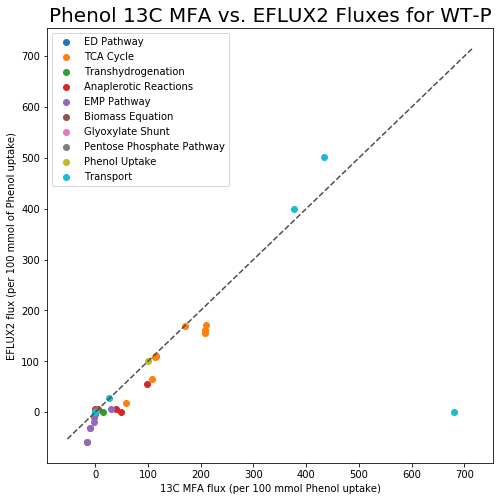

In [26]:
scatterplotcomp_obs_vs_pred(obspred_fluxes, substrate='phenol', method='EFLUX2', linename='WT-P')

##### **Plot observations vs. predictions with confidence intervals**

In [27]:
import matplotlib
import matplotlib.cm as cm
def scatterplotcomp_obs_vs_pred_withstd(obspred_fluxes, substrate, method, linename):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

    for pathway in list(set(obspred_fluxes['Pathway'])):
        pathway_df = obspred_fluxes[obspred_fluxes['Pathway'] == pathway]
        
        measured_flux_list = list(pathway_df['Flux'])
        simulated_flux_list = list(pathway_df[str(method) + ' Value'])
        simulated_std_list = list(pathway_df[str(method) + ' std Value'])
        measured_std_list = list(pathway_df['90% Confidence Upper Bound']-pathway_df['Flux'])
        
        
        sc = ax.scatter(measured_flux_list, simulated_flux_list, label=pathway)
        ax.errorbar(
                measured_flux_list, simulated_flux_list, xerr=[std1 for std1 in measured_std_list], yerr=[1.9*std for std in simulated_std_list],
                    ecolor="gray", ls='none',
                    alpha=0.8)

    # Dashed line
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x, ls="--", c=".3")
    if substrate=='phenol':
        sub = 'Phenol'
    elif substrate=='glucose':
        sub = 'Glucose'
    else:
        print("Unknown substrate")
    plt.title(r''+str(sub)+  ' 13C MFA vs. '+ str(method) + ' Fluxes for ' +linename, fontSize=20)
    plt.xlabel(r'13C MFA flux (per 100 mmol '+str(sub)+  ' uptake)')
    plt.ylabel(r''+ str(method) + ' flux (per 100 mmol of '+str(sub)+  ' uptake)')
    plt.legend()
    plt.show()

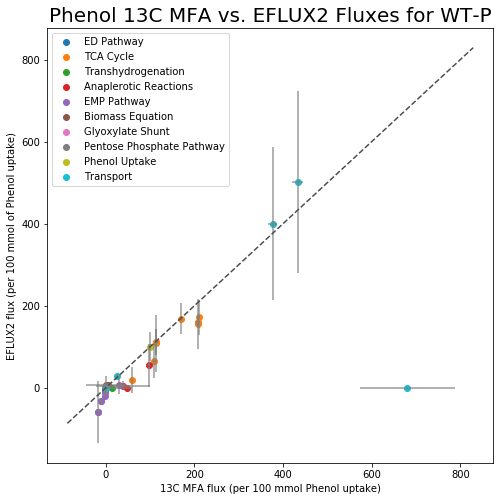

In [28]:
scatterplotcomp_obs_vs_pred_withstd(obspred_fluxes, substrate='phenol', method='EFLUX2', linename='WT-P')

##### **PVHG-P**

In [29]:
#Function for EFLUX2 and SPOT Predictions:
def eflux2pred(model, transcriptdf, linename, substrate, sub_uptake_rate, conditionstring):    
    with model:
        medium = model.medium
        if substrate=='phenol':
            model.objective = 'Growth_Phenol'
            model.reactions.get_by_id('Growth_Glucose').upper_bound = 0
            model.reactions.get_by_id('Growth_Glucose').lower_bound = 0
            medium = {key:np.inf for (key,value) in model.medium.items()}
            medium["EX_glc__D_e"] = 0.0
            #medium["EX_phenol_e"] = sub_uptake_rate
        elif substrate=='glucose':
            model.objective = 'Growth_Glucose'
            model.reactions.get_by_id('Growth_Phenol').upper_bound = 0
            model.reactions.get_by_id('Growth_Phenol').lower_bound = 0
            medium = {key:np.inf for (key,value) in model.medium.items()}
            #medium["EX_glc__D_e"] = sub_uptake_rate
            medium["EX_phenol_e"] = 0.0
        else:
            print('Unknown substrate: Please choose among phenol and glucose')
        model.medium = medium
        eflux2sol = EFlux2(model, transcriptdf)
        display(model.medium)
    return eflux2sol

In [30]:
#Function for predictions for three replicates and averaging the solutions and calculating the standard deviation:
def eflux2predthreereps(model, transcriptdf, linename1, linename2, linename3, substrate, sub_uptake_rate, conditionstring):
    #call prediction functions for individual EFLUX2 predictions for all 3 replicates:
    transdata_R1 = constructTransdffrompred(transcriptdf, linename1, conditionstring)
    transdata_R2 = constructTransdffrompred(transcriptdf, linename2, conditionstring)
    transdata_R3 = constructTransdffrompred(transcriptdf, linename3, conditionstring)
 
    eflux2sol_R1 = eflux2pred(model, transdata_R1, linename1, substrate, sub_uptake_rate, conditionstring)
    eflux2sol_R2 = eflux2pred(model, transdata_R2, linename2, substrate, sub_uptake_rate, conditionstring)
    eflux2sol_R3 = eflux2pred(model, transdata_R3, linename3, substrate, sub_uptake_rate, conditionstring)
    
    #EFLUX2 calculations:
    eflux2sol_R1_df = pd.DataFrame(eflux2sol_R1.fluxes, columns=['fluxes'])
    eflux2sol_R2_df = pd.DataFrame(eflux2sol_R2.fluxes, columns=['fluxes'])
    eflux2sol_R3_df = pd.DataFrame(eflux2sol_R3.fluxes, columns=['fluxes'])
    eflux2sol_all = pd.concat([eflux2sol_R1_df, eflux2sol_R2_df, eflux2sol_R3_df], axis=1)

    eflux2sol = pd.DataFrame(eflux2sol_all.mean(axis=1), columns=['fluxes'])
    eflux2sol_std = eflux2sol_all.std(axis=1)
    
    return eflux2sol, eflux2sol_std

In [31]:
eflux2sol_PVHG, eflux2sol_std_PVHG = eflux2predthreereps(model, df_Trans, 'PVHG-P-R1', 'PVHG-P-R2','PVHG-P-R3', 'phenol', 100, '0.5 g/l PHE as carbon source')#eflux2sol, eflux2sol_std = eflux2spotpredthreereps(model, df_Trans2, 'WT-P-R1', 'WT-P-R2','WT-P-R3', 'phenol', 100)

FBA status optimal
FBA solution 31.43702022378916


Problem infeasible or unbounded: to be added value for transbound will be set to  1000000.0  instead of np.inf
FBA status optimal
FBA solution 31.43702022378916


EFlux2 status optimal
EFlux2 solution 19557241.235760808


{'EX_h2o_e': inf,
 'EX_h_e': inf,
 'EX_cl_e': inf,
 'EX_pi_e': inf,
 'EX_nh4_e': inf,
 'EX_fe3_e': inf,
 'EX_k_e': inf,
 'EX_ca2_e': inf,
 'EX_mg2_e': inf,
 'EX_mn2_e': inf,
 'EX_cobalt2_e': inf,
 'EX_zn2_e': inf,
 'EX_cu2_e': inf,
 'EX_o2_e': inf,
 'EX_fe2_e': inf,
 'EX_mobd_e': inf,
 'EX_so4_e': inf,
 'EX_phenol_e': inf}

FBA status optimal
FBA solution 31.43702022378916


Problem infeasible or unbounded: to be added value for transbound will be set to  1000000.0  instead of np.inf
FBA status optimal
FBA solution 31.43702022378916


EFlux2 status optimal
EFlux2 solution 19557241.235760808


{'EX_h2o_e': inf,
 'EX_h_e': inf,
 'EX_cl_e': inf,
 'EX_pi_e': inf,
 'EX_nh4_e': inf,
 'EX_fe3_e': inf,
 'EX_k_e': inf,
 'EX_ca2_e': inf,
 'EX_mg2_e': inf,
 'EX_mn2_e': inf,
 'EX_cobalt2_e': inf,
 'EX_zn2_e': inf,
 'EX_cu2_e': inf,
 'EX_o2_e': inf,
 'EX_fe2_e': inf,
 'EX_mobd_e': inf,
 'EX_so4_e': inf,
 'EX_phenol_e': inf}

FBA status optimal
FBA solution 31.43702022378916


Problem infeasible or unbounded: to be added value for transbound will be set to  1000000.0  instead of np.inf
FBA status optimal
FBA solution 31.43702022378916


EFlux2 status optimal
EFlux2 solution 19557241.235760808


{'EX_h2o_e': inf,
 'EX_h_e': inf,
 'EX_cl_e': inf,
 'EX_pi_e': inf,
 'EX_nh4_e': inf,
 'EX_fe3_e': inf,
 'EX_k_e': inf,
 'EX_ca2_e': inf,
 'EX_mg2_e': inf,
 'EX_mn2_e': inf,
 'EX_cobalt2_e': inf,
 'EX_zn2_e': inf,
 'EX_cu2_e': inf,
 'EX_o2_e': inf,
 'EX_fe2_e': inf,
 'EX_mobd_e': inf,
 'EX_so4_e': inf,
 'EX_phenol_e': inf}

##### **Save solution to data frame**

In [32]:
eflux2soldf_PVHG = pd.DataFrame(eflux2sol_PVHG, columns=['fluxes'])
eflux2solstddf_PVHG = pd.DataFrame(eflux2sol_std_PVHG, columns=['stds'])

In [33]:
factorpv=eflux2soldf.loc['EX_phenol_e']/2.069

##### **Check External Metabolites solution**

In [34]:
exchange_list = []
for ind in eflux2soldf.index:
    if 'EX_' in str(ind):
        exchange_list.append(ind)

In [35]:
eflux2soldf.loc[exchange_list,:]
for i in exchange_list:
    if abs(eflux2soldf.loc[i,:].values)>=0.0001:
        display(eflux2soldf.loc[i,:])

fluxes    15.261482
Name: EX_h2o_e, dtype: float64

fluxes    1.864641
Name: EX_h_e, dtype: float64

fluxes   -0.002033
Name: EX_cl_e, dtype: float64

fluxes   -0.845827
Name: EX_pi_e, dtype: float64

fluxes   -2.625001
Name: EX_nh4_e, dtype: float64

fluxes   -0.003049
Name: EX_fe3_e, dtype: float64

fluxes   -0.076227
Name: EX_k_e, dtype: float64

fluxes   -0.002033
Name: EX_ca2_e, dtype: float64

fluxes   -0.003388
Name: EX_mg2_e, dtype: float64

fluxes   -0.00027
Name: EX_mn2_e, dtype: float64

fluxes   -0.000133
Name: EX_zn2_e, dtype: float64

fluxes    25.003678
Name: EX_co2_e, dtype: float64

fluxes   -0.000277
Name: EX_cu2_e, dtype: float64

fluxes   -31.303435
Name: EX_o2_e, dtype: float64

fluxes   -0.002622
Name: EX_fe2_e, dtype: float64

fluxes   -0.022649
Name: EX_so4_e, dtype: float64

fluxes   -6.246863
Name: EX_phenol_e, dtype: float64

##### **Check FBA solution**

In [36]:
with model:
    medium = model.medium
    model.objective = 'Growth_Phenol'
    model.reactions.get_by_id('Growth_Glucose').upper_bound = 0
    model.reactions.get_by_id('Growth_Glucose').lower_bound = 0
    #sub_uptake_rate = 1.76124#just copied value to test it
    #medium["EX_phenol_e"] = sub_uptake_rate
    model.medium = medium
    # solve FBA to calculate the maximum biomass
    boundedfba_sol = model.optimize()
    print('Unbounded FBA status', boundedfba_sol.status)
    print('Unbounded FBA solution', boundedfba_sol.objective_value)

Unbounded FBA status optimal
Unbounded FBA solution 0.801735654966415


##### **Add  Phenol PVHG EFLUX2 and SPOT flux values to phenol fluxes dataframe**

In [37]:
obspred_fluxes2 = addpredfluxes_to13cdf(obspred_fluxes, eflux2soldf_PVHG, eflux2solstddf_PVHG, 'phenol', 'EFLUX2')

'factor'

fluxes    0.303773
Name: EX_phenol_e, dtype: float64

In [38]:
obspred_fluxes2

,Pathway,Forward Reactions,Reaction,Location on map,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound,EFLUX2 Value,EFLUX2 std Value
0,Phenol Uptake,PHEMOX,Phenol.ext -> AcCoA + SucCoA,"( 80, -450)",1.000000e+02,1.000000e+02,100.0000,100.000000,0.000000e+00
1,EMP Pathway,PGI,G6P <-> F6P,"(-150, 430)",-4.793000e-01,-1.421900e+00,0.9306,-4.243637,0.000000e+00
2,EMP Pathway,PFK or reverse_FBP,F6P + ATP -> FBP,"(-220, 195)",-2.000000e+00,-2.000000e+00,-0.7683,-15.462221,0.000000e+00
3,EMP Pathway,FBA,FBP <-> DHAP + GAP,"(-140, 115)",-2.000000e+00,-2.000000e+00,-0.7683,-15.462221,0.000000e+00
4,EMP Pathway,TPI,DHAP <-> GAP,"(-270, 150)",-2.000000e+00,-2.000000e+00,-0.7683,-28.629104,0.000000e+00
5,EMP Pathway,GAPD,"GAP <-> G1,3P","(-220, 30)",-1.079070e+01,-1.122350e+01,-9.1040,-47.017012,0.000000e+00
6,EMP Pathway,reverse_PGK,"G1,3P <-> 3PG + ATP + NADH","(-220, -55)",-1.079070e+01,-1.122350e+01,-9.1040,-47.017012,0.000000e+00
7,EMP Pathway,PGM_1 or reverse_PGM,3PG <-> 2PG,"(-220, -135)",-1.625380e+01,-1.695560e+01,-13.6034,-54.959072,0.000000e+00
8,EMP Pathway,ENO,2PG <-> PEP,"(-220, -215)",-1.625380e+01,-1.695560e+01,-13.6034,-54.959072,0.000000e+00
9,EMP Pathway,PPS or reverse_FRUpts2pp or reverse_SBTpts or ...,PEP <-> Pyr + ATP,"(-220, -295)",2.999990e+01,0.000000e+00,30.0000,0.000000,0.000000e+00


#### Plot EFLUX2 vs 13C MFA

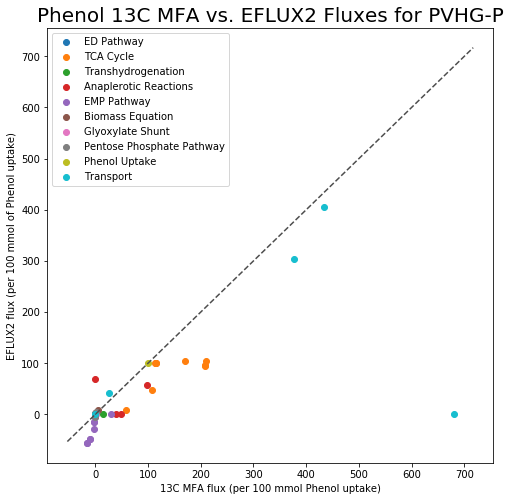

In [39]:
scatterplotcomp_obs_vs_pred(obspred_fluxes2, substrate='phenol', method='EFLUX2', linename='PVHG-P')

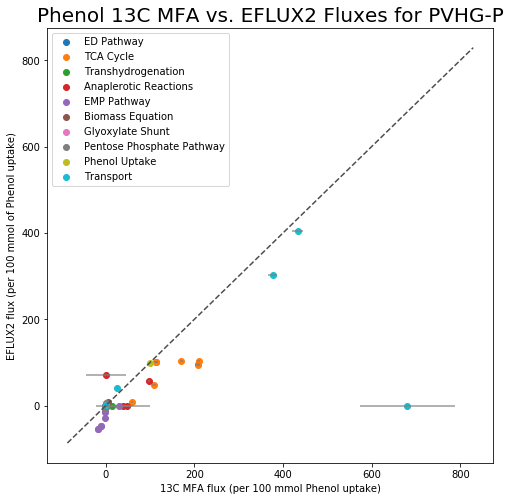

In [40]:
scatterplotcomp_obs_vs_pred_withstd(obspred_fluxes2, substrate='phenol', method='EFLUX2',linename='PVHG-P')

## Phenol EFlux Flux Map

Define a function to convert a predicted flux data frame column to a flux map

In [41]:
def map_flux_results(data_df, flux_column):
    fig, ax = plt.subplots(figsize=(15, 20), dpi=50)
    xy = (0.5, 0.5)
    arr_img = plt.imread('./unlabeled_flux_map.png')
    imagebox = OffsetImage(arr_img)
    imagebox.image.axes = ax
    ab = AnnotationBbox(imagebox, xy)
    ax.add_artist(ab)

    for _, row in data_df.iterrows():
        if not pd.isnull(row['Location on map']):
            location =  row['Location on map'].replace('(', '').replace(')', '')
            location_list = location.split(',')
            location_tuple = tuple((int(location_list[0]), int(location_list[1])))

            offsetbox = TextArea(f'{row[flux_column]:.1f}',textprops=dict(fontsize=22))
            ab = AnnotationBbox(offsetbox, xy,
                                xybox=location_tuple,
                                xycoords='data',
                                boxcoords="offset points",
                                frameon=False)
            ax.add_artist(ab)

    # Fix the display limits to see everything
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xticks([])
    ax.set_yticks([])

    plt.show()

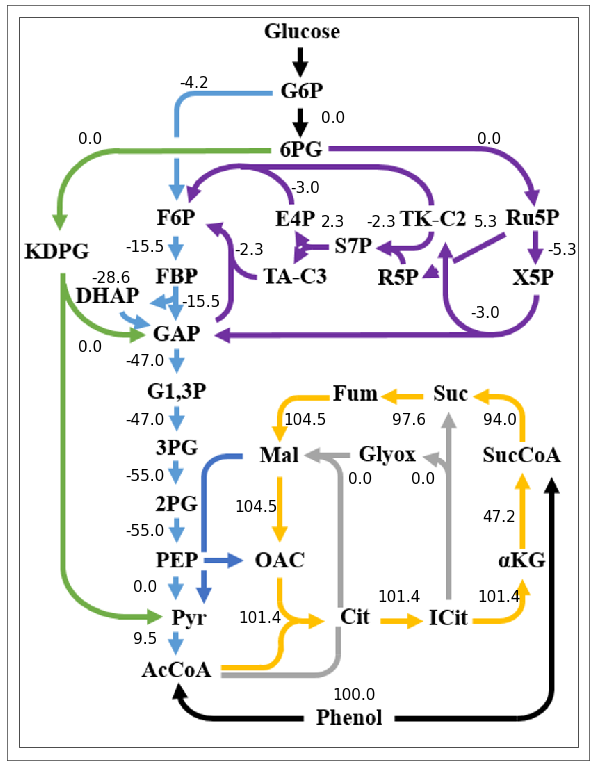

In [42]:
map_flux_results(obspred_fluxes, 'EFLUX2 Value')

#### **SPOT Predictions**

In [43]:
#Function for EFLUX2 and SPOT Predictions:
def spotpred(model, transcriptdf, linename, substrate, sub_uptake_rate, conditionstring):    
    with model:
        medium = model.medium
        if substrate=='phenol':
            model.objective = 'Growth_Phenol'
            model.reactions.get_by_id('Growth_Glucose').upper_bound = 0
            model.reactions.get_by_id('Growth_Glucose').lower_bound = 0
            medium = {key:np.inf for (key,value) in model.medium.items()}
            medium["EX_glc__D_e"] = 0.0
            #medium["EX_phenol_e"] = sub_uptake_rate
        elif substrate=='glucose':
            model.objective = 'Growth_Glucose'
            model.reactions.get_by_id('Growth_Phenol').upper_bound = 0
            model.reactions.get_by_id('Growth_Phenol').lower_bound = 0
            medium = {key:np.inf for (key,value) in model.medium.items()}
            #medium["EX_glc__D_e"] = sub_uptake_rate
            medium["EX_phenol_e"] = 0.0
        else:
            print('Unknown substrate: Please choose among phenol and glucose')
        model.medium = medium
        spotsol = SPOT(model, transcriptdf)
        display(model.medium)
    return spotsol

In [44]:
#Function for predictions for three replicates and averaging the solutions and calculating the standard deviation:
def spotpredthreereps(model, transcriptdf, linename1, linename2, linename3, substrate, sub_uptake_rate, conditionstring):
    #call prediction functions for individual spot predictions for all 3 replicates:
    transdata_R1 = constructTransdffrompred(transcriptdf, linename1, conditionstring)
    transdata_R2 = constructTransdffrompred(transcriptdf, linename2, conditionstring)
    transdata_R3 = constructTransdffrompred(transcriptdf, linename3, conditionstring)
 
    spotsol_R1 = spotpred(model, transdata_R1, linename1, substrate, sub_uptake_rate, conditionstring)
    spotsol_R2 = spotpred(model, transdata_R2, linename2, substrate, sub_uptake_rate, conditionstring)
    spotsol_R3 = spotpred(model, transdata_R3, linename3, substrate, sub_uptake_rate, conditionstring)
    
    #spot calculations:
    spotsol_R1_df = pd.DataFrame(spotsol_R1, columns=['fluxes'])
    spotsol_R2_df = pd.DataFrame(spotsol_R2, columns=['fluxes'])
    spotsol_R3_df = pd.DataFrame(spotsol_R3, columns=['fluxes'])
    spotsol_all = pd.concat([spotsol_R1_df, spotsol_R2_df, spotsol_R3_df], axis=1)
    
    spotsol = pd.DataFrame(spotsol_all.mean(axis=1), columns=['fluxes'])
    spotsol_std = spotsol_all.std(axis=1)
    
    return spotsol, spotsol_std

In [45]:
spotsol, spotsol_std = spotpredthreereps(model, df_Trans, 'WT-P-R1', 'WT-P-R2','WT-P-R3', 'phenol', 100, '0.5 g/l PHE as carbon source')

{'EX_h2o_e': inf,
 'EX_h_e': inf,
 'EX_cl_e': inf,
 'EX_pi_e': inf,
 'EX_nh4_e': inf,
 'EX_fe3_e': inf,
 'EX_k_e': inf,
 'EX_ca2_e': inf,
 'EX_mg2_e': inf,
 'EX_mn2_e': inf,
 'EX_cobalt2_e': inf,
 'EX_zn2_e': inf,
 'EX_cu2_e': inf,
 'EX_o2_e': inf,
 'EX_fe2_e': inf,
 'EX_mobd_e': inf,
 'EX_so4_e': inf,
 'EX_phenol_e': inf}

{'EX_h2o_e': inf,
 'EX_h_e': inf,
 'EX_cl_e': inf,
 'EX_pi_e': inf,
 'EX_nh4_e': inf,
 'EX_fe3_e': inf,
 'EX_k_e': inf,
 'EX_ca2_e': inf,
 'EX_mg2_e': inf,
 'EX_mn2_e': inf,
 'EX_cobalt2_e': inf,
 'EX_zn2_e': inf,
 'EX_cu2_e': inf,
 'EX_o2_e': inf,
 'EX_fe2_e': inf,
 'EX_mobd_e': inf,
 'EX_so4_e': inf,
 'EX_phenol_e': inf}

{'EX_h2o_e': inf,
 'EX_h_e': inf,
 'EX_cl_e': inf,
 'EX_pi_e': inf,
 'EX_nh4_e': inf,
 'EX_fe3_e': inf,
 'EX_k_e': inf,
 'EX_ca2_e': inf,
 'EX_mg2_e': inf,
 'EX_mn2_e': inf,
 'EX_cobalt2_e': inf,
 'EX_zn2_e': inf,
 'EX_cu2_e': inf,
 'EX_o2_e': inf,
 'EX_fe2_e': inf,
 'EX_mobd_e': inf,
 'EX_so4_e': inf,
 'EX_phenol_e': inf}

{'EX_h2o_e': inf,
 'EX_h_e': inf,
 'EX_cl_e': inf,
 'EX_pi_e': inf,
 'EX_nh4_e': inf,
 'EX_fe3_e': inf,
 'EX_k_e': inf,
 'EX_ca2_e': inf,
 'EX_mg2_e': inf,
 'EX_mn2_e': inf,
 'EX_cobalt2_e': inf,
 'EX_zn2_e': inf,
 'EX_cu2_e': inf,
 'EX_o2_e': inf,
 'EX_fe2_e': inf,
 'EX_mobd_e': inf,
 'EX_so4_e': inf,
 'EX_phenol_e': inf}

{'EX_h2o_e': inf,
 'EX_h_e': inf,
 'EX_cl_e': inf,
 'EX_pi_e': inf,
 'EX_nh4_e': inf,
 'EX_fe3_e': inf,
 'EX_k_e': inf,
 'EX_ca2_e': inf,
 'EX_mg2_e': inf,
 'EX_mn2_e': inf,
 'EX_cobalt2_e': inf,
 'EX_zn2_e': inf,
 'EX_cu2_e': inf,
 'EX_o2_e': inf,
 'EX_fe2_e': inf,
 'EX_mobd_e': inf,
 'EX_so4_e': inf,
 'EX_phenol_e': inf}

{'EX_h2o_e': inf,
 'EX_h_e': inf,
 'EX_cl_e': inf,
 'EX_pi_e': inf,
 'EX_nh4_e': inf,
 'EX_fe3_e': inf,
 'EX_k_e': inf,
 'EX_ca2_e': inf,
 'EX_mg2_e': inf,
 'EX_mn2_e': inf,
 'EX_cobalt2_e': inf,
 'EX_zn2_e': inf,
 'EX_cu2_e': inf,
 'EX_o2_e': inf,
 'EX_fe2_e': inf,
 'EX_mobd_e': inf,
 'EX_so4_e': inf,
 'EX_phenol_e': inf}

##### **Save solution to data frame**

In [46]:
spotsoldf = pd.DataFrame(spotsol, columns=['fluxes'])
spotsolstddf = pd.DataFrame(spotsol_std, columns=['stds'])

##### **Check External Metabolites solution**

In [47]:
exchange_list = []
for ind in spotsoldf.index:
    if 'EX_' in str(ind):
        exchange_list.append(ind)

In [48]:
spotsoldf.loc[exchange_list,:]
for i in exchange_list:
    if abs(spotsoldf.loc[i,:].values)>=0.0001:
        display(spotsoldf.loc[i,:])
    

fluxes   -0.034485
Name: EX_h2o_e, dtype: float64

fluxes    0.141765
Name: EX_h_e, dtype: float64

fluxes    0.001381
Name: EX_leu__L_e, dtype: float64

fluxes    0.004106
Name: EX_acac_e, dtype: float64

fluxes    0.002868
Name: EX_acald_e, dtype: float64

fluxes   -0.003313
Name: EX_nh4_e, dtype: float64

fluxes    0.064964
Name: EX_succ_e, dtype: float64

fluxes    0.110086
Name: EX_co2_e, dtype: float64

fluxes   -0.201771
Name: EX_o2_e, dtype: float64

fluxes    0.002212
Name: EX_fum_e, dtype: float64

fluxes    0.000253
Name: EX_pdima_e, dtype: float64

fluxes    0.001952
Name: EX_val__L_e, dtype: float64

fluxes   -0.073865
Name: EX_phenol_e, dtype: float64

##### **Check FBA solution**

In [49]:
with model:
    medium = model.medium
    model.objective = 'Growth_Phenol'
    model.reactions.get_by_id('Growth_Glucose').upper_bound = 0
    model.reactions.get_by_id('Growth_Glucose').lower_bound = 0
    #sub_uptake_rate = 1.76124# just copied value to test it
    medium["EX_glc__D_e"] = 0.0
    #medium["EX_phenol_e"] = sub_uptake_rate
    model.medium = medium
    # solve FBA to calculate the maximum biomass
    boundedfba_sol = model.optimize()
    print('Unbounded FBA status', boundedfba_sol.status)
    print('Unbounded FBA solution', boundedfba_sol.objective_value)

Unbounded FBA status optimal
Unbounded FBA solution 0.2357789548122888


##### **Add Phenol EFLUX2 and SPOT flux values to phenol fluxes dataframe**

In [50]:
obspred_fluxesnew = addpredfluxes_to13cdf(obspred_fluxes, spotsoldf, spotsolstddf, 'phenol', 'SPOT')

'factor'

fluxes    1353.81363
Name: EX_phenol_e, dtype: float64

In [51]:
obspred_fluxesnew

,Pathway,Forward Reactions,Reaction,Location on map,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound,EFLUX2 Value,EFLUX2 std Value,SPOT Value,SPOT std Value
0,Phenol Uptake,PHEMOX,Phenol.ext -> AcCoA + SucCoA,"( 80, -450)",1.000000e+02,1.000000e+02,100.0000,100.000000,0.000000e+00,100.000000,4.719834e+01
1,EMP Pathway,PGI,G6P <-> F6P,"(-150, 430)",-4.793000e-01,-1.421900e+00,0.9306,-4.243637,0.000000e+00,0.008631,3.698246e-06
2,EMP Pathway,PFK or reverse_FBP,F6P + ATP -> FBP,"(-220, 195)",-2.000000e+00,-2.000000e+00,-0.7683,-15.462221,0.000000e+00,0.011512,3.868923e-06
3,EMP Pathway,FBA,FBP <-> DHAP + GAP,"(-140, 115)",-2.000000e+00,-2.000000e+00,-0.7683,-15.462221,0.000000e+00,0.011472,4.247451e-06
4,EMP Pathway,TPI,DHAP <-> GAP,"(-270, 150)",-2.000000e+00,-2.000000e+00,-0.7683,-28.629104,0.000000e+00,0.023553,6.941382e-06
5,EMP Pathway,GAPD,"GAP <-> G1,3P","(-220, 30)",-1.079070e+01,-1.122350e+01,-9.1040,-47.017012,0.000000e+00,0.045777,1.769886e-02
6,EMP Pathway,reverse_PGK,"G1,3P <-> 3PG + ATP + NADH","(-220, -55)",-1.079070e+01,-1.122350e+01,-9.1040,-47.017012,0.000000e+00,0.045777,-1.769886e-02
7,EMP Pathway,PGM_1 or reverse_PGM,3PG <-> 2PG,"(-220, -135)",-1.625380e+01,-1.695560e+01,-13.6034,-54.959072,0.000000e+00,2.461340,-8.664191e-04
8,EMP Pathway,ENO,2PG <-> PEP,"(-220, -215)",-1.625380e+01,-1.695560e+01,-13.6034,-54.959072,0.000000e+00,4.218549,7.203401e+00
9,EMP Pathway,PPS or reverse_FRUpts2pp or reverse_SBTpts or ...,PEP <-> Pyr + ATP,"(-220, -295)",2.999990e+01,0.000000e+00,30.0000,0.000000,0.000000e+00,-55.133710,-2.515439e+01


### Plot SPOT vs 13C MFA

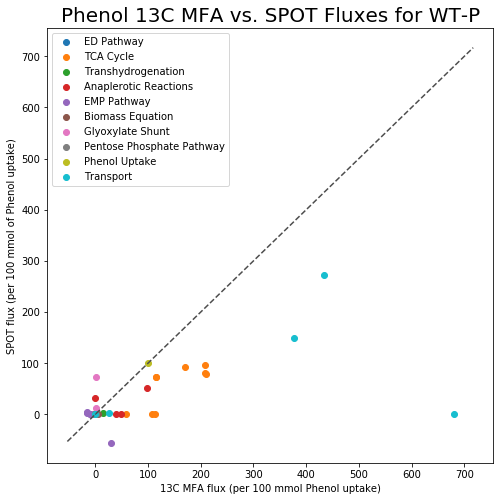

In [52]:
scatterplotcomp_obs_vs_pred(obspred_fluxesnew, substrate='phenol', method='SPOT', linename='WT-P')

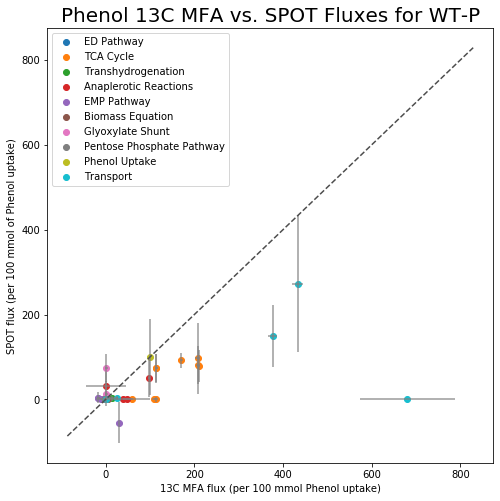

In [53]:
scatterplotcomp_obs_vs_pred_withstd(obspred_fluxesnew, substrate='phenol', method='SPOT', linename='WT-P')

##### **PVHG**

In [54]:
spotsol_PVHG, spotsol_std_PVHG = spotpredthreereps(model, df_Trans, 'PVHG-P-R1', 'PVHG-P-R2','PVHG-P-R3', 'phenol', 100, '0.5 g/l phenol as carbon source')

{'EX_h2o_e': inf,
 'EX_h_e': inf,
 'EX_cl_e': inf,
 'EX_pi_e': inf,
 'EX_nh4_e': inf,
 'EX_fe3_e': inf,
 'EX_k_e': inf,
 'EX_ca2_e': inf,
 'EX_mg2_e': inf,
 'EX_mn2_e': inf,
 'EX_cobalt2_e': inf,
 'EX_zn2_e': inf,
 'EX_cu2_e': inf,
 'EX_o2_e': inf,
 'EX_fe2_e': inf,
 'EX_mobd_e': inf,
 'EX_so4_e': inf,
 'EX_phenol_e': inf}

{'EX_h2o_e': inf,
 'EX_h_e': inf,
 'EX_cl_e': inf,
 'EX_pi_e': inf,
 'EX_nh4_e': inf,
 'EX_fe3_e': inf,
 'EX_k_e': inf,
 'EX_ca2_e': inf,
 'EX_mg2_e': inf,
 'EX_mn2_e': inf,
 'EX_cobalt2_e': inf,
 'EX_zn2_e': inf,
 'EX_cu2_e': inf,
 'EX_o2_e': inf,
 'EX_fe2_e': inf,
 'EX_mobd_e': inf,
 'EX_so4_e': inf,
 'EX_phenol_e': inf}

{'EX_h2o_e': inf,
 'EX_h_e': inf,
 'EX_cl_e': inf,
 'EX_pi_e': inf,
 'EX_nh4_e': inf,
 'EX_fe3_e': inf,
 'EX_k_e': inf,
 'EX_ca2_e': inf,
 'EX_mg2_e': inf,
 'EX_mn2_e': inf,
 'EX_cobalt2_e': inf,
 'EX_zn2_e': inf,
 'EX_cu2_e': inf,
 'EX_o2_e': inf,
 'EX_fe2_e': inf,
 'EX_mobd_e': inf,
 'EX_so4_e': inf,
 'EX_phenol_e': inf}

{'EX_h2o_e': inf,
 'EX_h_e': inf,
 'EX_cl_e': inf,
 'EX_pi_e': inf,
 'EX_nh4_e': inf,
 'EX_fe3_e': inf,
 'EX_k_e': inf,
 'EX_ca2_e': inf,
 'EX_mg2_e': inf,
 'EX_mn2_e': inf,
 'EX_cobalt2_e': inf,
 'EX_zn2_e': inf,
 'EX_cu2_e': inf,
 'EX_o2_e': inf,
 'EX_fe2_e': inf,
 'EX_mobd_e': inf,
 'EX_so4_e': inf,
 'EX_phenol_e': inf}

{'EX_h2o_e': inf,
 'EX_h_e': inf,
 'EX_cl_e': inf,
 'EX_pi_e': inf,
 'EX_nh4_e': inf,
 'EX_fe3_e': inf,
 'EX_k_e': inf,
 'EX_ca2_e': inf,
 'EX_mg2_e': inf,
 'EX_mn2_e': inf,
 'EX_cobalt2_e': inf,
 'EX_zn2_e': inf,
 'EX_cu2_e': inf,
 'EX_o2_e': inf,
 'EX_fe2_e': inf,
 'EX_mobd_e': inf,
 'EX_so4_e': inf,
 'EX_phenol_e': inf}

{'EX_h2o_e': inf,
 'EX_h_e': inf,
 'EX_cl_e': inf,
 'EX_pi_e': inf,
 'EX_nh4_e': inf,
 'EX_fe3_e': inf,
 'EX_k_e': inf,
 'EX_ca2_e': inf,
 'EX_mg2_e': inf,
 'EX_mn2_e': inf,
 'EX_cobalt2_e': inf,
 'EX_zn2_e': inf,
 'EX_cu2_e': inf,
 'EX_o2_e': inf,
 'EX_fe2_e': inf,
 'EX_mobd_e': inf,
 'EX_so4_e': inf,
 'EX_phenol_e': inf}

##### **Save solution to data frame**

In [55]:
spotsoldf_PVHG = pd.DataFrame(spotsol_PVHG, columns=['fluxes'])
spotsolstddf_PVHG = pd.DataFrame(spotsol_std_PVHG, columns=['stds'])

##### **Add Phenol PVHG EFLUX2 and SPOT flux values to phenol fluxes dataframe**

In [56]:
obspred_fluxesnew2 = addpredfluxes_to13cdf(obspred_fluxes, spotsoldf_PVHG, spotsolstddf_PVHG, 'phenol', 'SPOT')

'factor'

fluxes    1772.842465
Name: EX_phenol_e, dtype: float64

In [57]:
obspred_fluxesnew2

,Pathway,Forward Reactions,Reaction,Location on map,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound,EFLUX2 Value,EFLUX2 std Value,SPOT Value,SPOT std Value
0,Phenol Uptake,PHEMOX,Phenol.ext -> AcCoA + SucCoA,"( 80, -450)",1.000000e+02,1.000000e+02,100.0000,100.000000,0.000000e+00,100.000000,0.000000e+00
1,EMP Pathway,PGI,G6P <-> F6P,"(-150, 430)",-4.793000e-01,-1.421900e+00,0.9306,-4.243637,0.000000e+00,-4.226369,0.000000e+00
2,EMP Pathway,PFK or reverse_FBP,F6P + ATP -> FBP,"(-220, 195)",-2.000000e+00,-2.000000e+00,-0.7683,-15.462221,0.000000e+00,-11.410260,0.000000e+00
3,EMP Pathway,FBA,FBP <-> DHAP + GAP,"(-140, 115)",-2.000000e+00,-2.000000e+00,-0.7683,-15.462221,0.000000e+00,-10.085373,0.000000e+00
4,EMP Pathway,TPI,DHAP <-> GAP,"(-270, 150)",-2.000000e+00,-2.000000e+00,-0.7683,-28.629104,0.000000e+00,-14.844692,0.000000e+00
5,EMP Pathway,GAPD,"GAP <-> G1,3P","(-220, 30)",-1.079070e+01,-1.122350e+01,-9.1040,-47.017012,0.000000e+00,-27.870403,0.000000e+00
6,EMP Pathway,reverse_PGK,"G1,3P <-> 3PG + ATP + NADH","(-220, -55)",-1.079070e+01,-1.122350e+01,-9.1040,-47.017012,0.000000e+00,-27.870403,0.000000e+00
7,EMP Pathway,PGM_1 or reverse_PGM,3PG <-> 2PG,"(-220, -135)",-1.625380e+01,-1.695560e+01,-13.6034,-54.959072,0.000000e+00,-37.781950,2.124594e-18
8,EMP Pathway,ENO,2PG <-> PEP,"(-220, -215)",-1.625380e+01,-1.695560e+01,-13.6034,-54.959072,0.000000e+00,-36.393575,0.000000e+00
9,EMP Pathway,PPS or reverse_FRUpts2pp or reverse_SBTpts or ...,PEP <-> Pyr + ATP,"(-220, -295)",2.999990e+01,0.000000e+00,30.0000,0.000000,0.000000e+00,3.489349,4.647549e-19


#### Plot SPOT vs 13C MFA

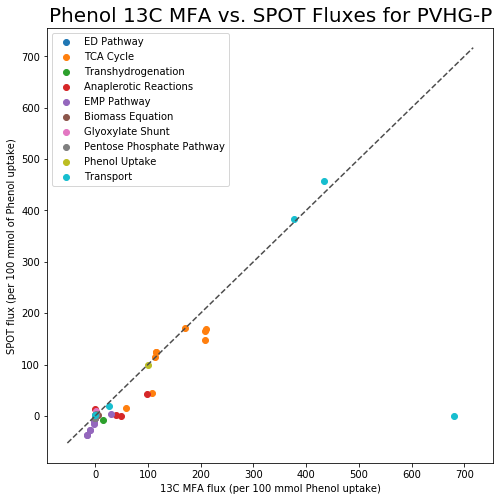

In [58]:
scatterplotcomp_obs_vs_pred(obspred_fluxesnew2, substrate='phenol', method='SPOT', linename='PVHG-P')

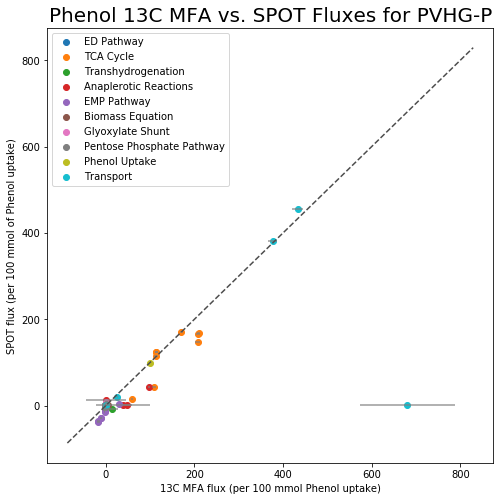

In [59]:
scatterplotcomp_obs_vs_pred_withstd(obspred_fluxesnew2, substrate='phenol', method='SPOT',linename='PVHG-P')

### Map phenol SPOT fluxes

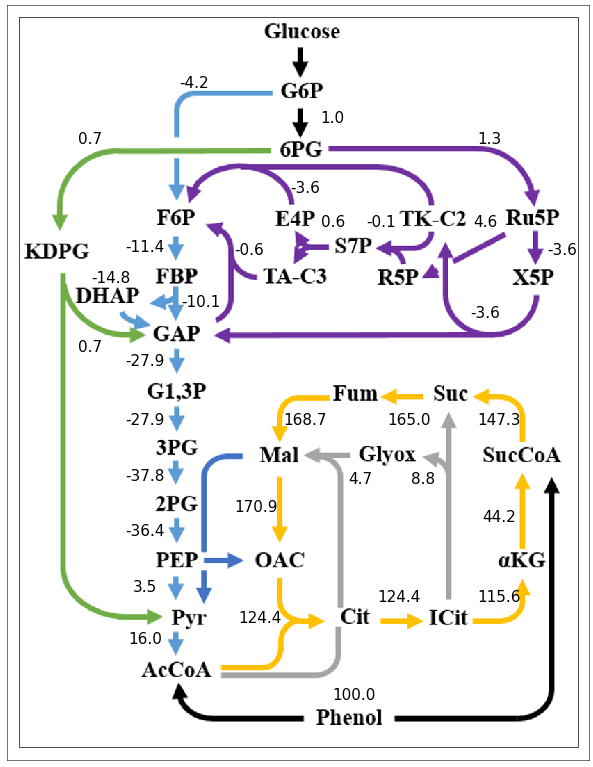

In [60]:
map_flux_results(obspred_fluxes, 'SPOT Value')

### Run phenol flux FBA

In [61]:
with model:
    model.objective = 'Growth_Phenol'
    mediumphe = model.medium
    
    # This is to prevent medium components other than phenol from being growth limitations
    mediumphe = {key:1000 for (key,value) in model.medium.items()}
    
    mediumphe["EX_glc__D_e"] = 0.0
    mediumphe["EX_phenol_e"] = 100.0
    
    model.medium = mediumphe
    solutionphe = model.optimize()
    
print(solutionphe)

<Solution 9.550 at 0x7f1619c7c910>


In [62]:
for r in model.metabolites.get_by_id('phenol_e').reactions:
    print(solutionphe.fluxes[r.id], r)
for r in model.metabolites.get_by_id('phenol_c').reactions:
    print(solutionphe.fluxes[r.id], r)

-100.0 EX_phenol_e: phenol_e <=> 
100.0 phenol_transport: phenol_e <=> phenol_c
100.0 phenol_transport: phenol_e <=> phenol_c
100.0 PHEMOX: h_c + nadh_c + o2_c + phenol_c --> catechol_c + h2o_c + nad_c


### Add Phenol FBA flux values to test_df 

In [63]:
FBA_fluxes_phe = []
for _, row in phenol_fluxes.iterrows():
    reactions = row['Forward Reactions']
    flux_value_phe = 0
    for x in [x.strip('() ') for x in reactions.split(' or ')]:
        and_split = [y.strip('() ') for y in x.split(' and ')]
        flux_value_phe += min([get_flux_value(v, solutionphe) for v in and_split])
    FBA_fluxes_phe.append(flux_value_phe)
    
phenol_fluxes['FBA Value'] = FBA_fluxes_phe
phenol_fluxes

,Pathway,Forward Reactions,Reaction,Location on map,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound,EFLUX2 Value,EFLUX2 std Value,SPOT Value,SPOT std Value,FBA Value
0,Phenol Uptake,PHEMOX,Phenol.ext -> AcCoA + SucCoA,"( 80, -450)",1.000000e+02,1.000000e+02,100.0000,100.000000,0.000000e+00,100.000000,0.000000e+00,100.000000
1,EMP Pathway,PGI,G6P <-> F6P,"(-150, 430)",-4.793000e-01,-1.421900e+00,0.9306,-4.243637,0.000000e+00,-4.226369,0.000000e+00,-4.243637
2,EMP Pathway,PFK or reverse_FBP,F6P + ATP -> FBP,"(-220, 195)",-2.000000e+00,-2.000000e+00,-0.7683,-15.462221,0.000000e+00,-11.410260,0.000000e+00,-15.462221
3,EMP Pathway,FBA,FBP <-> DHAP + GAP,"(-140, 115)",-2.000000e+00,-2.000000e+00,-0.7683,-15.462221,0.000000e+00,-10.085373,0.000000e+00,-15.462221
4,EMP Pathway,TPI,DHAP <-> GAP,"(-270, 150)",-2.000000e+00,-2.000000e+00,-0.7683,-28.629104,0.000000e+00,-14.844692,0.000000e+00,-28.629104
5,EMP Pathway,GAPD,"GAP <-> G1,3P","(-220, 30)",-1.079070e+01,-1.122350e+01,-9.1040,-47.017012,0.000000e+00,-27.870403,0.000000e+00,-47.017012
6,EMP Pathway,reverse_PGK,"G1,3P <-> 3PG + ATP + NADH","(-220, -55)",-1.079070e+01,-1.122350e+01,-9.1040,-47.017012,0.000000e+00,-27.870403,0.000000e+00,-47.017012
7,EMP Pathway,PGM_1 or reverse_PGM,3PG <-> 2PG,"(-220, -135)",-1.625380e+01,-1.695560e+01,-13.6034,-54.959072,0.000000e+00,-37.781950,2.124594e-18,-54.959072
8,EMP Pathway,ENO,2PG <-> PEP,"(-220, -215)",-1.625380e+01,-1.695560e+01,-13.6034,-54.959072,0.000000e+00,-36.393575,0.000000e+00,-54.959072
9,EMP Pathway,PPS or reverse_FRUpts2pp or reverse_SBTpts or ...,PEP <-> Pyr + ATP,"(-220, -295)",2.999990e+01,0.000000e+00,30.0000,0.000000,0.000000e+00,3.489349,4.647549e-19,0.000000


### Get r<sup>2</sup>  values 

In [64]:
# remove Energy molecule reactions as they are outliers
r_squared_df = phenol_fluxes[~phenol_fluxes['Reaction'].isin(['ATP -> ATP.ext', 'NADH <-> NADPH'])]


_, _, EFlux_r, _, _ = scipy.stats.linregress(r_squared_df['Flux'], r_squared_df['EFLUX2 Value'])
_, _, FBA_r,   _, _  = scipy.stats.linregress(r_squared_df['Flux'], r_squared_df['FBA Value'])

print(f'E-Flux2 vs 13C-MFA r-squared: {EFlux_r**2:.4F}')
print(f'FBA vs 13C-MFA r-squared: {FBA_r**2:.4F}')

E-Flux2 vs 13C-MFA r-squared: 0.8905
FBA vs 13C-MFA r-squared: 0.8064


In [65]:
r_squared_df

,Pathway,Forward Reactions,Reaction,Location on map,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound,EFLUX2 Value,EFLUX2 std Value,SPOT Value,SPOT std Value,FBA Value
0,Phenol Uptake,PHEMOX,Phenol.ext -> AcCoA + SucCoA,"( 80, -450)",1.000000e+02,1.000000e+02,100.0000,100.000000,0.000000e+00,100.000000,0.000000e+00,100.000000
1,EMP Pathway,PGI,G6P <-> F6P,"(-150, 430)",-4.793000e-01,-1.421900e+00,0.9306,-4.243637,0.000000e+00,-4.226369,0.000000e+00,-4.243637
2,EMP Pathway,PFK or reverse_FBP,F6P + ATP -> FBP,"(-220, 195)",-2.000000e+00,-2.000000e+00,-0.7683,-15.462221,0.000000e+00,-11.410260,0.000000e+00,-15.462221
3,EMP Pathway,FBA,FBP <-> DHAP + GAP,"(-140, 115)",-2.000000e+00,-2.000000e+00,-0.7683,-15.462221,0.000000e+00,-10.085373,0.000000e+00,-15.462221
4,EMP Pathway,TPI,DHAP <-> GAP,"(-270, 150)",-2.000000e+00,-2.000000e+00,-0.7683,-28.629104,0.000000e+00,-14.844692,0.000000e+00,-28.629104
5,EMP Pathway,GAPD,"GAP <-> G1,3P","(-220, 30)",-1.079070e+01,-1.122350e+01,-9.1040,-47.017012,0.000000e+00,-27.870403,0.000000e+00,-47.017012
6,EMP Pathway,reverse_PGK,"G1,3P <-> 3PG + ATP + NADH","(-220, -55)",-1.079070e+01,-1.122350e+01,-9.1040,-47.017012,0.000000e+00,-27.870403,0.000000e+00,-47.017012
7,EMP Pathway,PGM_1 or reverse_PGM,3PG <-> 2PG,"(-220, -135)",-1.625380e+01,-1.695560e+01,-13.6034,-54.959072,0.000000e+00,-37.781950,2.124594e-18,-54.959072
8,EMP Pathway,ENO,2PG <-> PEP,"(-220, -215)",-1.625380e+01,-1.695560e+01,-13.6034,-54.959072,0.000000e+00,-36.393575,0.000000e+00,-54.959072
9,EMP Pathway,PPS or reverse_FRUpts2pp or reverse_SBTpts or ...,PEP <-> Pyr + ATP,"(-220, -295)",2.999990e+01,0.000000e+00,30.0000,0.000000,0.000000e+00,3.489349,4.647549e-19,0.000000


In [66]:
r_squared_df

,Pathway,Forward Reactions,Reaction,Location on map,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound,EFLUX2 Value,EFLUX2 std Value,SPOT Value,SPOT std Value,FBA Value
0,Phenol Uptake,PHEMOX,Phenol.ext -> AcCoA + SucCoA,"( 80, -450)",1.000000e+02,1.000000e+02,100.0000,100.000000,0.000000e+00,100.000000,0.000000e+00,100.000000
1,EMP Pathway,PGI,G6P <-> F6P,"(-150, 430)",-4.793000e-01,-1.421900e+00,0.9306,-4.243637,0.000000e+00,-4.226369,0.000000e+00,-4.243637
2,EMP Pathway,PFK or reverse_FBP,F6P + ATP -> FBP,"(-220, 195)",-2.000000e+00,-2.000000e+00,-0.7683,-15.462221,0.000000e+00,-11.410260,0.000000e+00,-15.462221
3,EMP Pathway,FBA,FBP <-> DHAP + GAP,"(-140, 115)",-2.000000e+00,-2.000000e+00,-0.7683,-15.462221,0.000000e+00,-10.085373,0.000000e+00,-15.462221
4,EMP Pathway,TPI,DHAP <-> GAP,"(-270, 150)",-2.000000e+00,-2.000000e+00,-0.7683,-28.629104,0.000000e+00,-14.844692,0.000000e+00,-28.629104
5,EMP Pathway,GAPD,"GAP <-> G1,3P","(-220, 30)",-1.079070e+01,-1.122350e+01,-9.1040,-47.017012,0.000000e+00,-27.870403,0.000000e+00,-47.017012
6,EMP Pathway,reverse_PGK,"G1,3P <-> 3PG + ATP + NADH","(-220, -55)",-1.079070e+01,-1.122350e+01,-9.1040,-47.017012,0.000000e+00,-27.870403,0.000000e+00,-47.017012
7,EMP Pathway,PGM_1 or reverse_PGM,3PG <-> 2PG,"(-220, -135)",-1.625380e+01,-1.695560e+01,-13.6034,-54.959072,0.000000e+00,-37.781950,2.124594e-18,-54.959072
8,EMP Pathway,ENO,2PG <-> PEP,"(-220, -215)",-1.625380e+01,-1.695560e+01,-13.6034,-54.959072,0.000000e+00,-36.393575,0.000000e+00,-54.959072
9,EMP Pathway,PPS or reverse_FRUpts2pp or reverse_SBTpts or ...,PEP <-> Pyr + ATP,"(-220, -295)",2.999990e+01,0.000000e+00,30.0000,0.000000,0.000000e+00,3.489349,4.647549e-19,0.000000


### Plot FBA vs 13C MFA

!!!To Do: Change functions to integrate no std situation!!!

#### WT-P

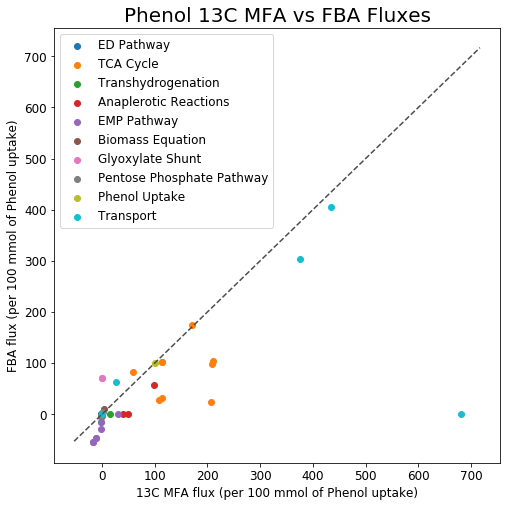

In [67]:
matplotlib.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

for pathway in list(set(phenol_fluxes['Pathway'])):
    pathway_df = phenol_fluxes[phenol_fluxes['Pathway'] == pathway]
    
    measured_flux_list = list(pathway_df['Flux'])
    simulated_flux_list = list(pathway_df['FBA Value'])
    
    ax.scatter(measured_flux_list, simulated_flux_list, label=pathway)


# Dashed line
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, ls="--", c=".3")

plt.title(r'Phenol 13C MFA vs FBA Fluxes', fontSize=20)
plt.xlabel(r'13C MFA flux (per 100 mmol of Phenol uptake)')
plt.ylabel(r'FBA flux (per 100 mmol of Phenol uptake)')
plt.legend()
plt.show()

### Map FBA Fluxes

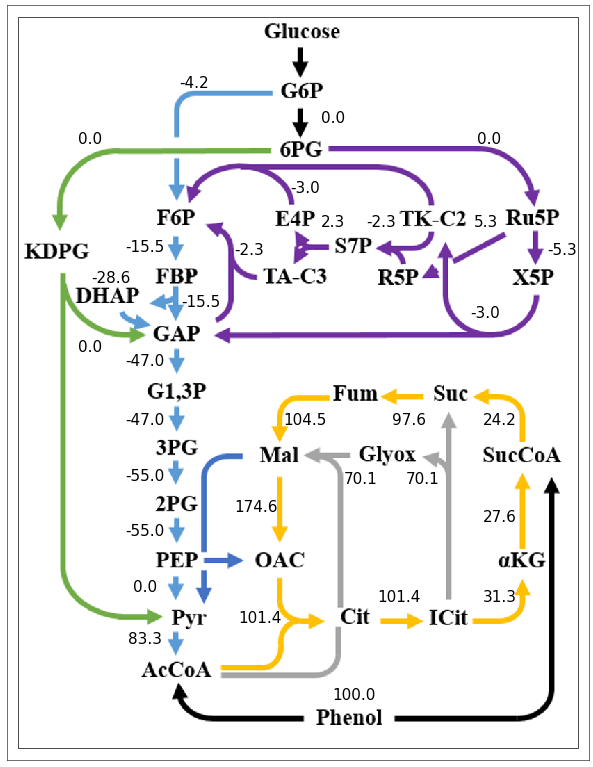

In [68]:
map_flux_results(obspred_fluxes, 'FBA Value')

### Map 13C MFA Fluxes

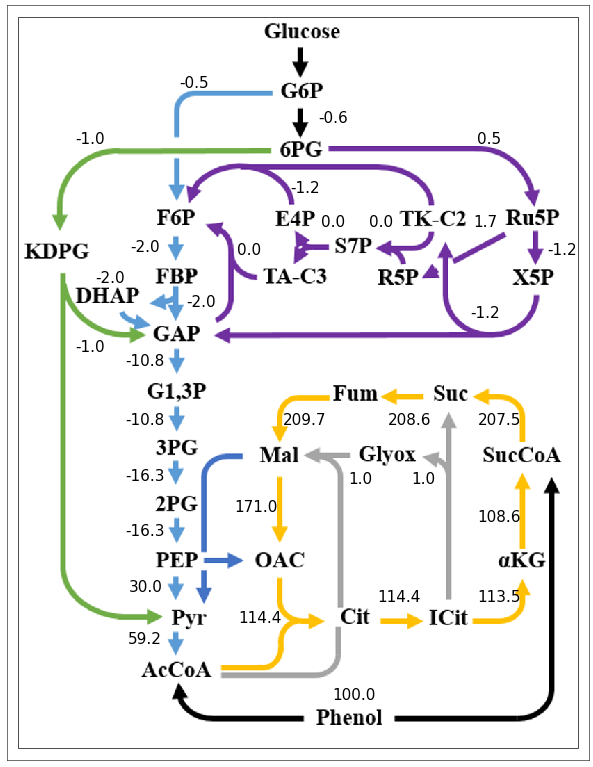

In [69]:
map_flux_results(obspred_fluxes, 'Flux')

#### Load observed growth rates and plot glucose and phenol growth rates

In [70]:
growthandsubstrdata = pd.read_csv('growthandsubstratedata.csv')

In [71]:
#Scatterplot of solutions
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import linregress

def maefunc(y_predict, y_actual):
    """Mean Absolute Error.
    Multioutput case included."""

    if y_actual.ndim == 1:
        return np.mean(np.abs([y_a - y_p for y_a, y_p in zip(y_actual, y_predict)]))
    else:
        return [
            np.mean(
                np.abs([y_a - y_p for y_a, y_p in zip(y_actual[:, i], y_predict[:, i])])
            )
            for i in range(y_actual.shape[1])
        ]
    
def scatterplotcompare(observed, predicted, labels, strtitle):
    fig, ax = plt.subplots(figsize=(8, 8))
    #res = stats.linregress(observed.to_numpy().astype(float), predicted.to_numpy())
    #print(res.rvalue**2)
    lims = [
                np.min([observed, predicted]),  # min of both axes
                np.max([observed, predicted]),  # max of both axes
            ]
    ax.set_xlim(lims)
    #ax.plot([0.0, 0.5], [0.0, 0.5], 'k',  c='0.55')
    # Plot Diagonal Dashed Line
    ax.plot(lims, lims, ls="--", color=".8", zorder=0)
    for i in range(0, len(observed)):
        ax.scatter(observed[i], predicted[i])
        ax.annotate(str(labels[i]),(observed[i],predicted[i]))
    #ax.annotate("r-squared = {:.3f}".format(round(r2_score(observed, predicted))), (0, 1))
    #plt.plot(observed, res.intercept + res.slope*observed, 'k', label='fitted line')
    rss = np.sum((predicted - observed) ** 2)
    tss = np.sum((predicted - predicted.mean()) ** 2)
    display(tss)
    r2_1 = 1 - rss / tss
    res = scipy.stats.linregress(observed.to_numpy(), predicted.to_numpy())
    r2_2 = res.rvalue**2
    #display(r2_1)
    #r2 = round(r2_score(observed, predicted),2)
    mse = np.round(1/len(observed) * rss,2) 
    rmse = np.round(np.sqrt(1/len(observed) * rss),2)
    #adjgrowth_r = 1 - (1- res.rvalue**2)*(len(observed)-1)/(len(observed)-2-1) 
    #display('adjusted_r', adjgrowth_r)
    #display(rmse)
    #display(r2_score(observed, predicted))
    mae_score = round(maefunc(observed, predicted),2)
    plt.xlabel(r'Observed growth rates [$mmol/gDW/hr$]')
    plt.ylabel(r'Predicted growth rates [$mmol/gDW/hr$]')
    plt.title(r'Growth rates: Observed vs. Predicted ('+strtitle+'), \n' + f"$R^2$={r2_2:.2F}, MAE={mae_score}, MSE = {mse}, RMSE={rmse}", fontsize=18)
    plt.show()

In [72]:
growthandsubstrdata.index = growthandsubstrdata['Unnamed: 0']
growthandsubstrdata.drop(['Unnamed: 0'], axis=1)

,growth_rate,yield_coeff,substrate_consumption_rate,growth_rate_std,yield_coeff_std,substr_cons_rate_std,FBA_growth_rate,pFBA_growth_rate,substrate uptake
Unnamed: 0,,,,,,,,,
WT-HN-HP,0.018808,0.028287,0.668193,0.001096,0.002990,0.031269,0.063811,0.063811,0.668193
EVOL33-HN-HP,0.033546,0.034836,0.964149,0.001738,0.002366,0.020354,0.092074,0.092074,0.964149
EVOL40-HN-HP,0.034101,0.038085,0.897184,0.001198,0.002455,0.028558,0.085679,0.085679,0.897184
WT-HN-G,0.031509,1.805065,0.017456,0.000000,0.000000,0.000000,0.002064,0.002064,0.017456
EVOL33-HN-G,0.031149,1.768135,0.017617,0.000000,0.000000,0.000000,0.002083,0.002083,0.017617
EVOL40-HN-G,0.031263,1.130288,0.027659,0.000000,0.000000,0.000000,0.003271,0.003271,0.027659
WT-LN-G,0.039004,2.307066,0.016906,0.000000,0.000000,0.000000,0.001999,0.001999,0.016906
EVOL33-LN-G,0.032741,1.057788,0.030953,0.000000,0.000000,0.000000,0.003660,0.003660,0.030953
EVOL40-LN-G,0.034156,2.133006,0.016013,0.000000,0.000000,0.000000,0.001893,0.001893,0.016013


In [73]:
growthandsubstrdata.index
growthandsubstrdata.loc['WT-P', 'growth_rate']

0.06548818848698068

In [88]:
allgrowthratesglucose = pd.read_csv('allgrowthratesGlucose.csv')
allgrowthratesglucose

,Unnamed: 0,Growth_Glucose_EFLUX2,Growth_Glucose_SPOT
0,WT-LN-G,-0.000977,2.971065e-06
1,EVOL33-LN-G,-0.001235,2.191482e-06
2,EVOL40-LN-G,-0.000801,4.417515e-07


In [75]:
allgrowthrates=pd.DataFrame(index=['WT-P', 'PVHG-P', 'WT-LN-G', 'EVOL33-LN-G', 'EVOL40-LN-G'], columns=['Growth_SPOT', 'Growth_EFLUX2'], dtype=float)

In [76]:
def scalegrowthtosub(solgrowth, soluptake, sub_uptake_2comp):
    factor = abs(sub_uptake_2comp)/abs(soluptake)
    display(abs(soluptake), abs(sub_uptake_2comp), factor)
    solgrowthnew = solgrowth*factor
    return solgrowthnew
scaledgrowthratespot_wtp = scalegrowthtosub(spotsoldf.loc['Growth_Phenol',:].values[0], spotsoldf.loc['EX_phenol_e',:].values[0],growthandsubstrdata.loc['WT-P', 'substrate_consumption_rate'])
scaledgrowthratespot_pvhgp = scalegrowthtosub(spotsoldf_PVHG.loc['Growth_Phenol',:].values[0], spotsoldf_PVHG.loc['EX_phenol_e',:].values[0],growthandsubstrdata.loc['PVHG-P', 'substrate_consumption_rate'])
scaledgrowthrate_wtp = scalegrowthtosub(eflux2soldf.loc['Growth_Phenol',:].values[0], eflux2soldf.loc['EX_phenol_e',:].values[0],growthandsubstrdata.loc['WT-P', 'substrate_consumption_rate'])
scaledgrowthrate_pvhgp = scalegrowthtosub(eflux2soldf_PVHG.loc['Growth_Phenol',:].values[0], eflux2soldf_PVHG.loc['EX_phenol_e',:].values[0],growthandsubstrdata.loc['PVHG-P', 'substrate_consumption_rate'])

0.07386541082841952

3.2414733241396383

43.88350769034767

0.056406591094584645

2.583189031605912

45.79587210427813

6.246863333321946

3.2414733241396383

0.5188961485437034

329.1927200186514

2.583189031605912

0.0078470417919921

In [77]:
allgrowthrates.at['WT-P','Growth_SPOT'] = scaledgrowthratespot_wtp#spotsoldf.loc['Growth_Glucose',:].values[0]
allgrowthrates.at['PVHG-P','Growth_SPOT'] = scaledgrowthratespot_pvhgp#spotsoldf_evol33.loc['Growth_Glucose',:].values[0]
allgrowthrates.at['WT-P','Growth_EFLUX2'] = scaledgrowthrate_wtp#eflux2soldf.loc['Growth_Glucose',:].values[0]#/366.324066
allgrowthrates.at['PVHG-P','Growth_EFLUX2'] = scaledgrowthrate_pvhgp#eflux2soldf_evol33.loc['Growth_Glucose',:].values[0]
allgrowthrates

,Growth_SPOT,Growth_EFLUX2
WT-P,-0.000008,0.208725
PVHG-P,0.025360,0.246688
WT-LN-G,NaN,NaN
EVOL33-LN-G,NaN,NaN
EVOL40-LN-G,NaN,NaN


In [78]:
# allgrowthrates.at['WT-P','Growth_SPOT'] = spotsoldf.loc['Growth_Phenol',:].values[0]
# allgrowthrates.at['PVHG-P','Growth_SPOT'] = spotsoldf_PVHG.loc['Growth_Phenol',:].values[0]
# allgrowthrates.at['WT-P','Growth_EFLUX2'] = eflux2soldf.loc['Growth_Phenol',:].values[0]
# allgrowthrates.at['PVHG-P','Growth_EFLUX2'] = eflux2soldf_PVHG.loc['Growth_Phenol',:].values[0]
allgrowthrates.at['WT-LN-G','Growth_SPOT'] = allgrowthratesglucose.loc[0,'Growth_Glucose_EFLUX2']
allgrowthrates.at['EVOL33-LN-G','Growth_SPOT'] = allgrowthratesglucose.loc[1,'Growth_Glucose_EFLUX2']
allgrowthrates.at['EVOL40-LN-G','Growth_SPOT'] = allgrowthratesglucose.loc[2,'Growth_Glucose_EFLUX2']
allgrowthrates.at['WT-LN-G','Growth_EFLUX2'] = allgrowthratesglucose.loc[0,'Growth_Glucose_SPOT']
allgrowthrates.at['EVOL33-LN-G','Growth_EFLUX2'] = allgrowthratesglucose.loc[1,'Growth_Glucose_SPOT']
allgrowthrates.at['EVOL40-LN-G','Growth_EFLUX2'] = allgrowthratesglucose.loc[2,'Growth_Glucose_SPOT']
allgrowthrates


,Growth_SPOT,Growth_EFLUX2
WT-P,-0.000008,2.087254e-01
PVHG-P,0.025360,2.466876e-01
WT-LN-G,-0.000977,2.971065e-06
EVOL33-LN-G,-0.001235,2.191482e-06
EVOL40-LN-G,-0.000801,4.417515e-07


In [79]:
growthrow = obspred_fluxes[obspred_fluxes['Pathway']=='Biomass Equation']
growthrate_eflux2 = float(growthrow['EFLUX2 Value'])
growthrow2 = obspred_fluxes2[obspred_fluxes2['Pathway']=='Biomass Equation']
growthrate_eflux22 = float(growthrow2['EFLUX2 Value'])

In [80]:
growthrate_eflux2

9.549731300864734

In [81]:
growthrate_eflux22

9.549731300864734

In [82]:
growthrow_spot = obspred_fluxesnew[obspred_fluxesnew['Pathway']=='Biomass Equation']
growthrate_spot = float(growthrow_spot['SPOT Value'])
growthrow_spot2 = obspred_fluxesnew2[obspred_fluxesnew2['Pathway']=='Biomass Equation']
growthrate_spot2 = float(growthrow_spot2['SPOT Value'])

In [83]:
growthrate_spot

1.1173017766494808

In [84]:
growthrate_spot2

1.1173017766494808

0.00032176478252935505

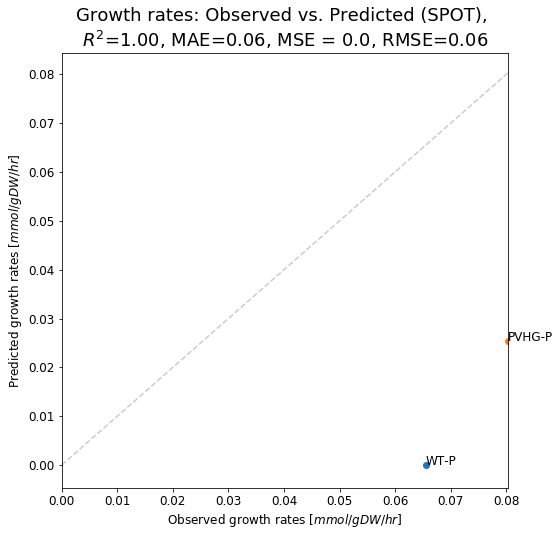

0.0007205662422117985

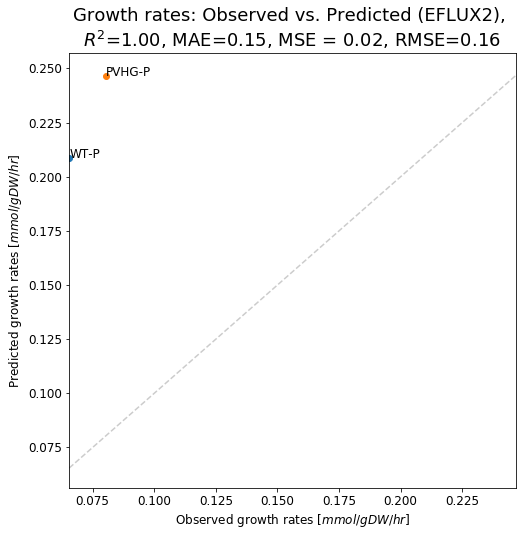

In [85]:
allindices=[str(row) for row in allgrowthrates.index]
scatterplotcompare(growthandsubstrdata.loc[['WT-P', 'PVHG-P'], 'growth_rate'], allgrowthrates.loc[['WT-P', 'PVHG-P'],'Growth_SPOT'], ['WT-P', 'PVHG-P'], 'SPOT')
scatterplotcompare(growthandsubstrdata.loc[['WT-P', 'PVHG-P'], 'growth_rate'], allgrowthrates.loc[['WT-P', 'PVHG-P'],'Growth_EFLUX2'], ['WT-P', 'PVHG-P'], 'EFLUX2')

Index(['WT-P', 'PVHG-P', 'WT-LN-G', 'EVOL33-LN-G', 'EVOL40-LN-G'], dtype='object')

0.0005464482012221934

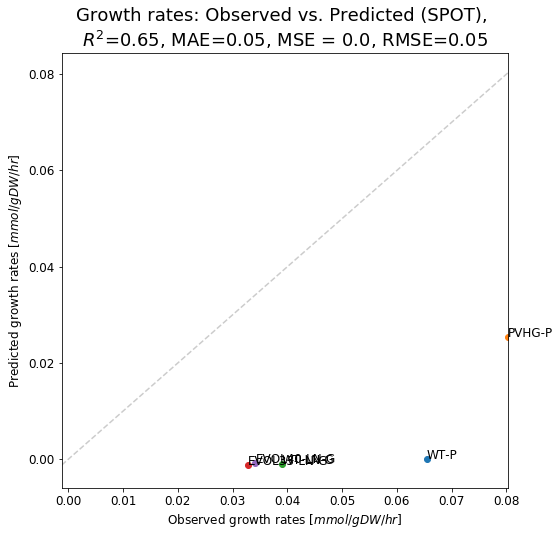

0.06293983792752356

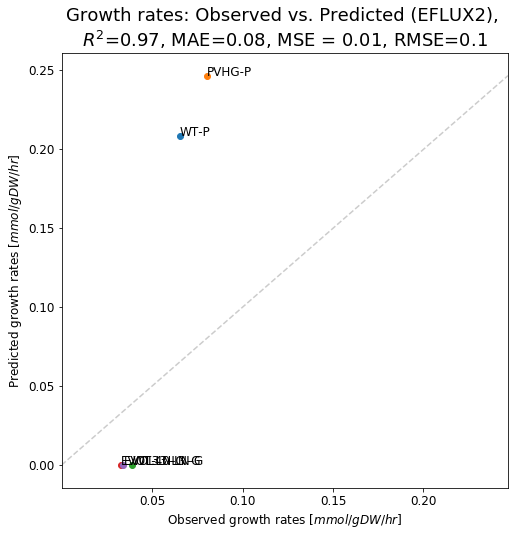

In [86]:
display(allgrowthrates.index)

allindices=[str(row) for row in allgrowthrates.index]
#display(growthandsubstrdata.loc[allindices,:])#'growth_rate'] 
scatterplotcompare(growthandsubstrdata.loc[allindices, 'growth_rate'], allgrowthrates.loc[allindices,'Growth_SPOT'], allindices, 'SPOT')
scatterplotcompare(growthandsubstrdata.loc[allindices, 'growth_rate'], allgrowthrates.loc[allindices,'Growth_EFLUX2'], allindices, 'EFLUX2')